In [2]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
import os 
print(os.getcwd())
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../ry/')
sys.path.append('../../')
sys.path.append('../')
import libry as ry
import time
import gc
import os
from collections import defaultdict
import utils

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
os.environ["ROS_IP"] = "129.69.216.200"

/home/niklas/git/uni/robotics-course/practical/clean


/home/niklas/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [4]:
"""
total ERROR = 0.00241405
total ERROR after radius correction = 0.00221046
*** total Pinv:
[0.00180045, 5.51994e-06, -0.569533, -0.0330757,
 -1.82321e-06, -0.00133149, 1.00136, 0.125005,
 5.08217e-05, -0.00117336, -0.439092, 1.55487]
*** camera intrinsics K:
[555.197, -8.21031, -334.467,
 0, -563.526, -271.392,
 0, 0, -1.02162]
*** camera world pos: [-0.0330757, 0.125005, 1.55487]
*** camera world rot: [0.935411, 0.35328, -0.0133783, 0.00451155]
"""
cam_world_pos= [-0.0330757, 0.125005, 1.55487]
cam_world_rot= [0.935411, 0.35328, -0.0133783, 0.00451155]
chestCamIntrinsics = {'fx': 555.197 , 
                       'fy':  -563.526, 
                       'cx': -334.467, 
                       'cy': -271.392, 'width': 640, 'height':480}
cam_rot = [0.935411, 0.35328, -0.0133783, 0.00451155]
K = np.array([
[555.197, -8.21031, -334.467],
 [0, -563.526, -271.392],
 [0, 0, -1.02162]
])
pinv_chest = np.array([[0.00180045, 5.51994e-06, -0.569533, -0.0330757],
  [-1.82321e-06, -0.00133149, 1.00136, 0.125005],
  [5.08217e-05, -0.00117336, -0.439092, 1.55487]])

In [5]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../rai-robotModels/baxter/baxter_new.g')
cam = C.addObject(name="cam", parent="base_footprint", shape=ry.ST.sphere, size=[0.01], color=[0,1,0], pos=cam_world_pos, quat=cam_world_rot)
nodeName = "camMarc"

q_home = C.getJointState()
q_zero = q_home.copy() * 0.
B = C.operate(nodeName)
B.sync(C)
C.makeObjectsConvex()
B.sendToReal(False)

In [ ]:
q_home

In [6]:
def check_target(targetFrame):
    if not targetFrame in C.getFrameNames():
        frame = C.addObject(name=targetFrame, parent="base_footprint" ,shape=ry.ST.sphere, size=[.01], pos=[0,0,0], color=[0.,0.,1.])
    return C.frame(targetFrame)

def close_gripper(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-2] = 0.04
    else:
        q[-2] = 0
    B.moveHard(q)

def plan_path(targetPos, angle, targetFrame, gripperFrame, steps, time):
    intermediatePos = cam_world_pos + 0.9 * (targetPos - cam_world_pos)
    intermediate = check_target("intermediate")
    target = check_target(targetFrame)
    rotA = utils.rotz(angle)
    rotC = utils.quat2rotm(cam_rot)
    rotM = rotA @ rotC
    B.sync(C)
    quat = utils.rotm2quat(rotM)
    target.setPosition(targetPos)
    intermediate.setPosition(intermediatePos)
    target.setQuaternion(quat)
    pp = C.komo_path(1, 30, 10, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductYZ, frames=[gripperFrame, targetFrame], target=[0], time=[.5, 1])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames= [gripperFrame, "cam"], target= [1], time= [.5, 1])
    #pp.addObjective(type= ry.OT.sos,feature= ry.FS.qItself, frames= [], target= q_home, time=[1.])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.distance, frames= [gripperFrame, 'intermediate'], target= [0], time= [.5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, targetFrame], target=[0,0,-0.04],time= [1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself, frames= [], order= 1,  time= [0, 1])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

In [7]:
B.sendToReal(True)
B.moveHard(q_home)
close_gripper(False)

In [ ]:
B.sendToReal(True)

In [ ]:
B.moveHard(q_zero)

In [8]:
from webserver import sampleClient
import vision
import cv2
from skimage import measure, morphology

In [9]:
cam = ry.Camera("camMarc", "/camera/rgb/image_rect_color", "/camera/depth/image_rect_raw", True)

In [10]:
img = cam.getRgb()
d = cam.getDepth()

In [ ]:
plt.imshow(img)

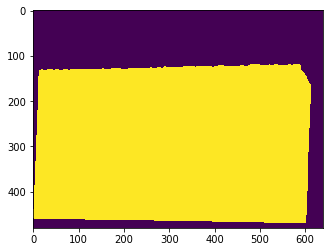

In [16]:
dm, m = vision.maskDepth(d, 0.7,1.4 )
m = cv2.medianBlur(m.astype(np.uint8), 5)
plt.imshow(m)

In [ ]:
sampleClient.predictRgb(img)

In [11]:
segmask = sampleClient.predictMask(d)


In [12]:
segmask["masks"].shape

(12, 480, 640)

In [ ]:
plt.imshow()

In [13]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [33]:
from matplotlib import colors
colors.to_rgb("AliceBlue")
image = img.copy()

In [41]:
rcolors = np.random.randint(0, len(STANDARD_COLORS), size=len(segmask["masks"]))
for i, mask in enumerate(segmask["masks"]):
    cnts = cv2.findContours(mask.astype(np.uint8),4, 8)
    for cn in cnts[0]:
        if not cv2.isContourConvex(cn):
            continue
    plt.figure()
    plt.imshow(mask)
    c = colors.to_rgb(STANDARD_COLORS[rcolors[i]])
    mask = np.bitwise_and(mask.astype(np.bool), m.astype(np.bool))
    colored = np.ones((*mask.shape, 3)) * c
    colored[~mask.astype(np.bool)] = 0
    image = cv2.addWeighted(image.astype(np.uint8),1, (colored * 255).astype(np.uint8), 0.9, 0)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [21]:
gx = 0
gy = 0 
def mouse_callback(event, x, y, flags, params):

    #right-click event value is 2
    if event == 1:
        global gx, gy

        #store the coordinates of the right-click event

        gx = x
        gy = y
        #this just verifies that the mouse data is being collected
        #you probably want to remove this later
        print(gx, gy)


#set mouse callback function for window
scale_width = 640 / image.shape[1]
scale_height = 480 / image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(image.shape[1] * scale)
window_height = int(image.shape[0] * scale)
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', window_width, window_height)
cv2.setMouseCallback('image', mouse_callback)
while(1):
    cv2.imshow('image',image)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        print (gx,gy)


394 355
382 322
447 307
403 283
285 207
282 203
380 352
371 313
355 297
430 307
364 266
355 321
440 334
362 288
388 344
418 337
360 324
320 288
611 292


KeyboardInterrupt: 

In [ ]:
grasp = sampleClient.predictGQCNN_pj(img, d, host="http://multitask.ddnss.de:5000", segmask=m, **chestCamIntrinsics)
vision.plotCircleAroundCenter(img, grasp["x"], grasp["y"])

In [ ]:
grasp = sampleClient.predictFCGQCNN_pj(img, d, m,host="http://multitask.ddnss.de:5000", **chestCamIntrinsics)
vision.plotCircleAroundCenter(img, grasp["x"], grasp["y"])

In [ ]:
grasp_p, x, y = vision.getGraspPosition_noIntr(d,grasp["x"], grasp["y"])
x = pinv_chest @ np.array(list(grasp_p) + [1])
steps = 30; time = 10
B.sendToReal(False)
B.moveHard(q_home)
p, pp = plan_path(x, grasp["angle"], "ball", "baxterR", steps, time)

In [ ]:
B.sendToReal(True)
close_gripper(False)
B.move(p, [time/steps * i for i in range(len(p))], False)

In [ ]:
close_gripper(True)

In [ ]:
B.moveHard(q_home)

In [ ]:
B.sendToReal(False)

In [ ]:
B.sendToReal(True)